# Applying Deep Learning to solve a Client Success problem - Duty Manager call prediction

GOAL: tackle a day-to-day Db2 Client Success problem using deep learning

PROBLEM CHOSEN: predict likelihood a ticket will generate a duty manager call

DATA SOURCE: ticketing dashboard (ticket details) 

FEATURES: TBD
    


APPROACH: start with a basic, working DL model and simplify/augment to optimizer prediction accuracy
- using this article on structured DL (i.e. DL on structured data, as opposed to common DL examples on unstructured data like images & audio) https://towardsdatascience.com/structured-deep-learning-b8ca4138b848 as a starting point, look for some examples of end-to-end DL on structured data. This article refers to a Kaggle competition on structured data, an entry in which https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl , for example, is a great end-to-end example
- use Keras (Python DL framework built on top of TensorFlow) - sweet spot for a simple, working DL model. Keras has decent documentation and a big enough community that answers to many questions are readily available
- once input data working through model, tune the following parameters to optimize validation/test accuracy (accuracy of prediction on data not used to generate model weights):
- learning rate (to avoid local minima and oscillation)
- dropout rate (control overfitting by randomly dropping nodes)
- lambda for L2 regularization (control overfitting by "suppressing" large weights)
- batch size (the number of training examples in a forward/backward pass)
- epochs run (number of complete passes through dataset)

ENVIRONMENTS USED:
- public cloud DSX: for most development and testing after initial setup and prior to adding non-Db2 data. PROS: convenient, persistent sessions, no cost; CONS: performance ~ 30% slower than PaperSpace, memory errors trying to run model on larger data set including text analysis
- Paperspace (https://www.paperspace.com/) low-cost generic GPU-enabled Linux environemnt. Used instructions from Jeremy Howard fast.ai course V2 to setup. PROS: better perf, able to handle text processing w. largest data set without memory errors, standard filesystem; CONS: setup not straightforward, inconvenience of having to start & stop environment
- initial development done on Paperspace, moved to DSX once the basics were working, then back to Paperspace after the larger data set began to generate memory errors in DSX

SOURCE DATA :

OVERVIEW OF CODE:
- ingest CSVs: need distinct code for DSX and paper
- various cleansing / slicing and dicing to generate additional features (e.g. year and day of week from date opened). Several variations attempted (e.g. make severity a continuous variable, distort severity at extremes, exclude some severities, exclude some TTR ranges) 
- define label / target: new column in dataframe that is 0 or 1 depending on whether TTR is less than or more than 1 day
- split data into training (which will be further split into training/validation) and test data sets (training data used to generate model weights; validation set used to track how well model predicts actual targets as hyperparameters are tuned; test set used to validate entire model (learned weights and hyperparameters)
- fill in missing values for all features
- in categorical columns (all feature columns currently) replace values (e.g. "CANADA", "JAPAN" for Country) with integer IDs
- process text columns - replace words with vector of integer IDs
- define Keras model:
- embedding layers for all categorical features (embeddings are vectors used to learn patterns for categorical data - https://en.wikipedia.org/wiki/Word_embedding )
- RNN layer for text feature
- single dense output layer w. sigmoid activation to output TTR prediction

CURRENT HWMs:

VARIATIONS ATTEMPTED:

DL Glossary: https://deeplearning4j.org/glossary

# Links to key parts of the notebook <a name='linkanchor' />
<a href=#ingestdash>Ingest data</a>

<a href=#definecategories>Define feature categories</a>

<a href=#bookmark>Deal with missing values</a>

<a href=#modelfit>Define and fit model</a>

<a href=#reload>Reload saved model and weights</a>

<a href=#confusionmatrix>Confusion matrix</a>

In [1]:
# set overall parameters

dsxmode = False # overall is this being run in DSX?
csvmode = True # ingest from CSV
dbmode = False # ingest from database
pSpace = True # pSpace mode

testproportion = 0.01 # proportion of data reserved for test set
trainproportion = 0.8 # proportion of non-test data dedicated to training (vs. validation)
verboseout = True
includetext = True # switch to determine whether text fields are included in model
presaved = False # switch to determine whether to train model or load saved model
savemodel = True # switch to determine whether to save model
hctextmax = 7000

targetthresh = 6.0
emptythresh = 1000
# to address imbalance in training data between zero (above targetthresh) and detractor (below targetthresh) specify weight in compile and fit
# class_weight = {0 : zero_weight, 1: one_weight}
# consider calculating these values from actual skew rather than hard-coding them here
zero_weight = 1.0
one_weight = 72.8

# hyperparameters
learning_rate = 0.001
dropout_rate = 0.0003 #0.003
l2_lambda = 0.0003 #7.5


In [2]:
import urllib.request
request = urllib.request.urlopen('http://www.google.com/')
#response = urllib.urlopen(request)
#if response.getcode() == 200:
#   print("200")

In [3]:
# common imports
import zipfile
import pandas as pd
import numpy as np
import time
import datetime
from dateutil import relativedelta
from io import StringIO
import pandas as pd

# DSX code to import uploaded documents
from io import StringIO
import requests
import json
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import math
from subprocess import check_output
import seaborn as sns

#model libraries


from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import backend as K
from keras.utils.vis_utils import plot_model


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Ingest data <a name='ingestdash' />
<a href=#linkanchor>Back to link list</a>

In [4]:
# @hidden_cell
import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
if csvmode == True and pSpace == False:
    client_da213e06995d4b47a69bc5d67be50adf = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='37JJGWzE_rBlEPTKq-F_Rc80arGWNCfnokq-8dQ9hMoH',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

    body = client_da213e06995d4b47a69bc5d67be50adf.get_object(Bucket='postidugdmcallpredictionmay2018-donotdelete-pr-hgavizfoy1yag2',Key='alldmeracasesmay142018j.csv')['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
    merged_data = pd.read_csv(body,encoding = "ISO-8859-1")
    merged_data.head()
    body = client_da213e06995d4b47a69bc5d67be50adf.get_object(Bucket='postidugdmcallpredictionmay2018-donotdelete-pr-hgavizfoy1yag2',Key='dmcasesmay142018.csv')['Body']
    # add missing __iter__ method, so pandas accepts body as file-like object
    if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
    # dm case from dm view
    dm_cases = pd.read_csv(body,encoding = "ISO-8859-1")
    dm_cases.head()
    # make column headers consistent with db col headers
    # data.columns = map(str.lower, data.columns)
    merged_data.columns = map(str.upper,merged_data.columns)
    dm_cases.columns = map(str.upper,dm_cases.columns)

In [5]:
# @hidden_cell
# ingest details of cases with DM call
from ibmdbpy import IdaDataBase, IdaDataFrame

# @hidden_cell
# This connection object is used to access your data and contains your credentials.
# You might want to remove those credentials before you share your notebook.


if csvmode == False and pSpace == False:
    idadb_edc167d9ba264fac87063ecca3030923 = IdaDataBase(dsn='DASHDB;Database=BLUDB;Hostname=awh-yp-small02.services.dal.bluemix.net;Port=50000;PROTOCOL=TCPIP;UID=dash100937;PWD=99QAkTsccX2d')
    dm_cases = IdaDataFrame(idadb_edc167d9ba264fac87063ecca3030923, 'DASH100937.DMCASESMAY142018').as_dataframe()
    merged_data = IdaDataFrame(idadb_edc167d9ba264fac87063ecca3030923, 'DASH100937.ALLDMERACASESMAY142018J').as_dataframe()
    dm_cases.head()


In [6]:
if pSpace == True:    
    dm_cases = pd.read_csv('/home/paperspace/data/dmprediction/dmcasesmay202018.csv',encoding = "ISO-8859-1")
    merged_data = pd.read_csv('/home/paperspace/data/dmprediction/alldmeracasesmay20.csv',encoding = "ISO-8859-1")
    merged_data.columns = map(str.upper,merged_data.columns)
    dm_cases.columns = map(str.upper,dm_cases.columns)



In [7]:
dm_cases.shape

(104, 14)

In [8]:
merged_data.shape

(7496, 11)

In [9]:
# columns = ['Col1', 'Col2', ...]
# df.drop(columns, inplace=True, axis=1)
dm_cases["target"] = 1

dm_cases.head()

,CASE_NUMBER,SUBJECT,OWNER_LAST_NAME,ACCOUNT_NAME_TEXT,CONTACT_NAME,ACCOUNT_PRIORITY,LEGACY_PROBLEM_NUMBER,SEVERITY_LEVEL,CASE_OWNER_ALIAS,BLUE_DIAMOND_ACCOUNT,COUNTRY,WATSON_SKILL_SUGGESTION_(DEPRECATED),STATUS,DATE_OPENED,target
0,TS000003163,FMP exiting with error and HeadExtentID 260611...,Ma,BELASTINGDIENST CAO,"Vannisselroy, Koen",Analytics-GEP,"28,585,211,788",3 - Minor business impact,majason,No,NL,NaN,Closed by IBM,08/11/2017,1
1,TS000003166,W R db2 load process hang for loading 5.8T rec...,BADIGER,CA Franchise Tax Board,"Jiang, Lily",NaN,"65,923,227,000",2 - Significant impact (any system is down),sbad,No,US,NaN,Closed - Archived,09/06/2017,1
2,TS000007186,UPDATE SYSSTAT.INDEXES hangs,Koranteng-Asante,"Lloyds Banking Group Service Delivery, Group IT","Nelson, Philip",NaN,Not Applicable,2 - Significant impact (any system is down),asan,No,GB,NaN,Closed - Archived,9/21/2017,1
3,TS000007630,Notified Load operation fails after revoking P...,Koranteng-Asante,STATE OF CONNECTICUT,"McCabe, Barbara",Analytics-Industry,Not Applicable,2 - Significant impact (any system is down),asan,No,US,NaN,Waiting for IBM,9/26/2017,1
4,TS000027965,Sporadic SQL SP slow performance due to invali...,Ma,21ST CENTURY INSURANCE AND FINANCIAL SERVICES,"Pentyala, Dileep Kumar",Analytics-Industry,Not Applicable,2 - Significant impact (any system is down),majason,No,US,NaN,Waiting for IBM,11/01/2017,1


In [10]:
dmcollist = list(dm_cases)
dmexlist = ['CASE_NUMBER','target']
# collist = list(set(nontextcols) - set(excludefromcolist) - set(nearempty))
dmcollist = list(set(dmcollist) - set(dmexlist))
dmcollist

['COUNTRY',
 'SUBJECT',
 'DATE_OPENED',
 'SEVERITY_LEVEL',
 'CASE_OWNER_ALIAS',
 'WATSON_SKILL_SUGGESTION_(DEPRECATED)',
 'BLUE_DIAMOND_ACCOUNT',
 'LEGACY_PROBLEM_NUMBER',
 'CONTACT_NAME',
 'ACCOUNT_PRIORITY',
 'STATUS',
 'OWNER_LAST_NAME',
 'ACCOUNT_NAME_TEXT']

In [11]:
# df.drop(columns, inplace=True, axis=1)
dm_cases.drop(dmcollist, inplace=True, axis=1)
print("dm_cases cols post pruning",list(dm_cases))

dm_cases cols post pruning ['CASE_NUMBER', 'target']


In [12]:
dm_cases.target.value_counts()

1    104
Name: target, dtype: int64

In [13]:
dm_cases.shape

(104, 2)

In [14]:
# merge the dm_cases dataframe with the overall cases dataframe
# caller.join(other.set_index('key'), on='key')
# merged_data = pd.merge(merged_data,dm_cases,on= 'CASE_NUMBER', how='outer')
# merged_data = pd.merge(merged_data,dm_cases,on= 'CASE_NUMBER', how='inner')
merged_data = merged_data.join(dm_cases.set_index('CASE_NUMBER'), on = 'CASE_NUMBER')

In [15]:
merged_data.shape

(7496, 12)

In [16]:
merged_data.head()

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,OWNERSHIP_CHANGES,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
0,TS000104648,CDel,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,"Marsh & McLennan Companies, Inc.",0,DB2 running out of disk space during data-inte...,Angel Georgiev,Not Applicable,NaN
1,TS000104657,barr,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,SOUTH AFRICAN REVENUE SVCS,1,C-3/27-(0)-W4F 180205 insert and delete transa...,Support ETL,"85,508,689,864",NaN
2,TS000104966,steffenh,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 3,SAP,1,SAP BCP 34020/2018 - DBA Cockpit Data Collecto...,Carola Langwald,Not Applicable,NaN
3,TS000105031,JKLA,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,SAP,1,SAP 47709/2018 - Productive Database db2 down ...,Malte Schünemann,Not Applicable,NaN
4,TS000105069,amri,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,INTERNATIONAL BUSINESS MACHINES,0,HADR tuning,Support ETL,"94,575,082,000",NaN


In [17]:
merged_data.target.value_counts()

1.0    84
Name: target, dtype: int64

In [18]:
# df.loc[df['column_name'] == some_value]
messed = merged_data.loc[merged_data['SUPPORT_MISSION'].isna()]
messed.head(20)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,OWNERSHIP_CHANGES,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target


In [19]:
# df['column']=df['column'].fillna(value)
merged_data['target']=merged_data['target'].fillna(0.0)
merged_data.target.value_counts()

0.0    7412
1.0      84
Name: target, dtype: int64

In [20]:
merged_data.shape

(7496, 12)

In [21]:
merged_data.head()

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,OWNERSHIP_CHANGES,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
0,TS000104648,CDel,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,"Marsh & McLennan Companies, Inc.",0,DB2 running out of disk space during data-inte...,Angel Georgiev,Not Applicable,0.0
1,TS000104657,barr,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,SOUTH AFRICAN REVENUE SVCS,1,C-3/27-(0)-W4F 180205 insert and delete transa...,Support ETL,"85,508,689,864",0.0
2,TS000104966,steffenh,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 3,SAP,1,SAP BCP 34020/2018 - DBA Cockpit Data Collecto...,Carola Langwald,Not Applicable,0.0
3,TS000105031,JKLA,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,SAP,1,SAP 47709/2018 - Productive Database db2 down ...,Malte Schünemann,Not Applicable,0.0
4,TS000105069,amri,02/01/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,INTERNATIONAL BUSINESS MACHINES,0,HADR tuning,Support ETL,"94,575,082,000",0.0


In [22]:
print("md shape",merged_data.shape)

md shape (7496, 12)


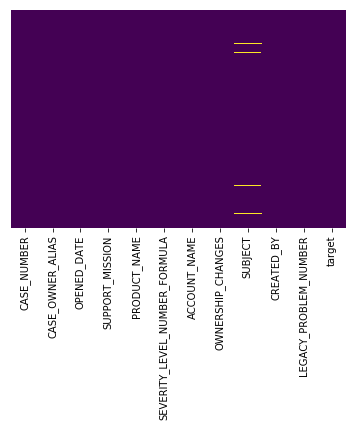

In [23]:
sns.heatmap(merged_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [24]:
nearempty = []
for c in merged_data.columns:
    if np.sum(merged_data[c].isnull()) >= emptythresh :
        print(c)
        nearempty.append(c)
print(nearempty)

[]


# Clean up data

Go through steps to prepare data.

# Define test / training sets; fill in missing values; encode categorical values; process text field

In [25]:
# get training and test data set
# test_size was 0.3 up to Jan 22

train, test = train_test_split(merged_data, test_size = testproportion)
print("Through train test split. Test proportion:")
print(testproportion)


Through train test split. Test proportion:
0.01


# Define feature categories <a name='definecategories' />
<a href=#linkanchor>Back to link list</a>

In [26]:
allcols = list(merged_data)
print("all cols",allcols)

all cols ['CASE_NUMBER', 'CASE_OWNER_ALIAS', 'OPENED_DATE', 'SUPPORT_MISSION', 'PRODUCT_NAME', 'SEVERITY_LEVEL_NUMBER_FORMULA', 'ACCOUNT_NAME', 'OWNERSHIP_CHANGES', 'SUBJECT', 'CREATED_BY', 'LEGACY_PROBLEM_NUMBER', 'target']


In [27]:
# define the required column lists

textcols = ['SUBJECT'] # columns to deal with as text - replace entries with multiple IDs and use embeddings, RNN
continuouscols = ['OWNERSHIP_CHANGES'] # columns to deal with as continuous values - no embeddings
excludefromcolist = ['CASE_NUMBER','target'] # columns to exclude completely from the model
# list(set(temp1) - set(temp2))
nontextcols = list(set(allcols) - set(textcols))
collist = list(set(nontextcols) - set(excludefromcolist) - set(nearempty) - set(continuouscols))

# print column list lengths and contents:
print("allcols",len(allcols))
print("nearempty",len(nearempty))
print(nearempty)
print("excludefromcolist",len(excludefromcolist))
print(excludefromcolist)
print("textcols",len(textcols))
print(textcols)
print("continuouscols",len(continuouscols))
print(continuouscols)
print("collist",len(collist))
print(collist)

allcols 12
nearempty 0
[]
excludefromcolist 2
['CASE_NUMBER', 'target']
textcols 1
['SUBJECT']
continuouscols 1
['OWNERSHIP_CHANGES']
collist 8
['SEVERITY_LEVEL_NUMBER_FORMULA', 'OPENED_DATE', 'ACCOUNT_NAME', 'SUPPORT_MISSION', 'CASE_OWNER_ALIAS', 'PRODUCT_NAME', 'CREATED_BY', 'LEGACY_PROBLEM_NUMBER']


In [28]:
# ensure continuous columns have numeric type
for col in continuouscols:
    merged_data[col] = merged_data[col].astype(float)

# Deal with missing values <a name='bookmark' />
<a href=#linkanchor>Back to link list</a>

In [29]:
# fill missing values
print("before mv")
def fill_missing(dataset):
    for col in collist:
        dataset[col].fillna(value="missing", inplace=True)
    for col in continuouscols:
        dataset[col].fillna(value=0.0,inplace=True)
    for col in textcols:
        dataset[col].fillna(value="missing", inplace=True)
    return (dataset)


train = fill_missing(train)
test = fill_missing(test)
train.head(3)


before mv


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,OWNERSHIP_CHANGES,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
2239,TS000137532,jshuang,03/08/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,IBM (China) Company Limited - SO,0,GCGTSC@DJ| Q replication issue,Support ETL,"91,418,124,672",0.0
2449,TS000139304,geof,03/09/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,PACIFICORP,0,TS000139304,Support ETL,"68,897,227,000",0.0
868,TS000180577,agko,4/13/2018,DB2 for LUW,"Db2 Linux, Unix and Windows",Severity 2,Banco do Brasil,1,SQL1224N The database manager is not able to ...,Support ETL,"15,265,250,631",0.0


In [30]:
# process categorical data
# replace values with category IDs in the following columns
# 


le = LabelEncoder()

for col in collist:
    if verboseout:
        print("processing ",col)
    le.fit(np.hstack([train[col], test[col]]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    
del le


train.head(5)
    

processing  SEVERITY_LEVEL_NUMBER_FORMULA
processing  OPENED_DATE
processing  ACCOUNT_NAME
processing  SUPPORT_MISSION


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


processing  CASE_OWNER_ALIAS
processing  PRODUCT_NAME
processing  CREATED_BY
processing  LEGACY_PROBLEM_NUMBER


,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,OWNERSHIP_CHANGES,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target
2239,TS000137532,155,19,0,4,1,889,0,GCGTSC@DJ| Q replication issue,1669,2355,0.0
2449,TS000139304,139,20,0,4,1,1467,0,TS000139304,1669,1906,0.0
868,TS000180577,99,83,0,4,1,292,1,SQL1224N The database manager is not able to ...,1669,214,0.0
2113,TS000113679,38,48,0,4,2,2022,0,DB2 APAR?IT09604?????,839,2570,0.0
5730,TS000590298,240,88,0,4,1,1493,1,[F12P7 MMDB] Large numbers of latch then cause...,499,2570,0.0


In [31]:
train['SUBJECT'].head(3)

2239                       GCGTSC@DJ| Q replication issue
2449                                          TS000139304
868     SQL1224N  The database manager is not able to ...
Name: SUBJECT, dtype: object

In [32]:
# part 1 of text processing
# tokenize list of text columns (made up of multiple strings)

from keras.preprocessing.text import Tokenizer

# text columns that we care about
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
# textcols = ['Resolution_Description', 'Subject']

for col in textcols:
    if verboseout:
        print("processing text col",col)
    
    # Tokenizer lower cases and removes punctuation by default
    tok_raw = Tokenizer(num_words=6000,lower=True)
    tok_raw.fit_on_texts(train[col])
    train[col] = tok_raw.texts_to_sequences(train[col])
    test[col] = tok_raw.texts_to_sequences(test[col])
    '''
    raw_text = train[col].str.lower()
    tok_raw = Tokenizer(lower=True)
    tok_raw.fit_on_texts(tok_raw)
    train[col] = tok_raw.texts_to_sequences(train[col].str.lower())
    test[col] = tok_raw.texts_to_sequences(test[col].str.lower())
    '''


processing text col SUBJECT


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
train['SUBJECT'].head(10)

2239                                [3, 274, 131, 86, 15]
2449                                               [2898]
868     [537, 11, 10, 134, 14, 13, 175, 2, 927, 171, 1...
2113                                       [1, 116, 2899]
5730    [1578, 1150, 321, 1329, 18, 442, 752, 427, 63,...
6649                                           [833, 249]
5390             [1, 160, 2900, 140, 1330, 182, 13, 2005]
788               [538, 361, 71, 72, 16, 2901, 229, 2902]
4642       [52, 153, 753, 2, 2903, 10, 35, 410, 65, 1151]
4884                                   [255, 5, 1579, 70]
Name: SUBJECT, dtype: object

In [34]:
# max values for embeddings



max_dict = {}
textmax = 50

for col in collist:
    max_dict[col] = np.max([train[col].max(), test[col].max()])+1
    
# np.max([np.max(train['Resolution_Description'].max()), np.max(train['Subject'].max()),np.max(train['Other_Reason_for_Cancellation'].max()),np.max(train['Reason_for_Reopening'].max())])) 
for cols in textcols:
    maxtrain = np.max(train[(train[cols].map(len) != 0)][cols].map(max))
    maxtest = np.max(test[(test[cols].map(len) != 0)][cols].map(max))
    if verboseout:
        print("maxtrain.max()",maxtrain)
        print("maxtest .max()",maxtest)
    max_dict[cols] = max(maxtrain,maxtest)
    # max_dict[cols] = np.max([np.max(train[cols].max()), np.max(test[cols].max())])+20
    # np.max(df[(df['seq_item_description'].map(len) != 0)].seq_item_description.map(max))
    if max_dict[cols] > textmax:
        textmax = max_dict[cols]

if textmax < hctextmax:
    textmax = hctextmax
        
print("textmax",textmax)
                             
if verboseout:
    print("max_dict",max_dict)



maxtrain.max() 5999
maxtest .max() 5933
textmax 7000
max_dict {'SEVERITY_LEVEL_NUMBER_FORMULA': 4, 'OPENED_DATE': 109, 'ACCOUNT_NAME': 2061, 'SUPPORT_MISSION': 1, 'CASE_OWNER_ALIAS': 249, 'PRODUCT_NAME': 23, 'CREATED_BY': 2082, 'LEGACY_PROBLEM_NUMBER': 2571, 'SUBJECT': 5999}


# Split training set into train / validate

In [35]:
# define and scale target and get validation sets
# apar_ds['TTRgtthresh'] = np.where(apar_ds['Time_to_relief'] >= ttrthresh,1,0)

# train["target"] = np.where(traintrain["LIKELIHOOD_TO_RECOMMEND"]

# train["target"] = train["Time_to_relief"]

#train["target"] = np.log(train.Time_to_relief+1)
#target_scaler = MinMaxScaler(feature_range=(-1, 1))
#train["target"] = target_scaler.fit_transform(train.target.reshape(-1,1))
#pd.DataFrame(train.target).hist()

# train_size 0.8 up to Jan 22
dtrain, dvalid = train_test_split(train, random_state=123, train_size=trainproportion)

# modelfit = model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
#          , validation_data=(X_valid, dvalid.target), verbose=1)

print(dtrain.shape)
print(dvalid.shape)
if verboseout:
    train["target"].head(10)
else:
    #trn_labels[:4]
    print(dtrain["target"][:2])
    print(dvalid.target[:2])
    




(5936, 12)
(1485, 12)


In [36]:
# print counts of target values for data sets
print("zero target values: all",(merged_data["target"]==0).sum())
print("one target values: all",(merged_data["target"]==1).sum())
print("zero target values: dtrain",(dtrain["target"]==0).sum())
print("one target values: dtrain",(dtrain["target"]==1).sum())
print("zero target values: dvalid",(dvalid["target"]==0).sum())
print("one target values: dvalid",(dvalid["target"]==1).sum())


zero target values: all 7412
one target values: all 84
zero target values: dtrain 5868
one target values: dtrain 68
zero target values: dvalid 1470
one target values: dvalid 15


In [37]:
# define keras variables
from keras.preprocessing.sequence import pad_sequences

# 'Country','Release','Comp_name','Dmcall','Severity','English_Spoken','Owner_ID','BE_Indicator','Customer','Technical_Resolver_ID'
# MAX_COUNTRY ,MAX_RELEASE ,MAX_COMP_NAME ,MAX_DMCALL ,MAX_SEVERITY ,MAX_ENGLISH_SPOKEN ,MAX_OWNER_ID ,MAX_BE_INDICATOR ,MAX_CUSTOMER ,MAX_TECHNICAL_RESOLVER_ID 
# FOLLOW UP - put this in a loop so it's not hard coded

# X for the features used

def get_keras_vars(dataset):
    X = {}
    for col in collist:
        X[col] = np.array(dataset[col])
        if verboseout:
            print("cat col is",col)
            print("shape is",X[col].shape)
            
   
    for col in continuouscols:
        X[col] = np.array(dataset[col])
        if verboseout:
            print("cont col is",col)
            print("shape is",X[col].shape)
       
    
    for col in textcols:
        X[col] = pad_sequences(dataset[col], maxlen=max_dict[col])
        if verboseout:
            print("text col is",col)
            print("shape is",X[col].shape)
        
    return X

X_train = get_keras_vars(dtrain)
X_valid = get_keras_vars(dvalid)
X_test = get_keras_vars(test)
print("keras variables defined")





cat col is SEVERITY_LEVEL_NUMBER_FORMULA
shape is (5936,)
cat col is OPENED_DATE
shape is (5936,)
cat col is ACCOUNT_NAME
shape is (5936,)
cat col is SUPPORT_MISSION
shape is (5936,)
cat col is CASE_OWNER_ALIAS
shape is (5936,)
cat col is PRODUCT_NAME
shape is (5936,)
cat col is CREATED_BY
shape is (5936,)
cat col is LEGACY_PROBLEM_NUMBER
shape is (5936,)
cont col is OWNERSHIP_CHANGES
shape is (5936,)
text col is SUBJECT
shape is (5936, 5999)
cat col is SEVERITY_LEVEL_NUMBER_FORMULA
shape is (1485,)
cat col is OPENED_DATE
shape is (1485,)
cat col is ACCOUNT_NAME
shape is (1485,)
cat col is SUPPORT_MISSION
shape is (1485,)
cat col is CASE_OWNER_ALIAS
shape is (1485,)
cat col is PRODUCT_NAME
shape is (1485,)
cat col is CREATED_BY
shape is (1485,)
cat col is LEGACY_PROBLEM_NUMBER
shape is (1485,)
cont col is OWNERSHIP_CHANGES
shape is (1485,)
text col is SUBJECT
shape is (1485, 5999)
cat col is SEVERITY_LEVEL_NUMBER_FORMULA
shape is (75,)
cat col is OPENED_DATE
shape is (75,)
cat col is A

In [82]:
# shortcut for quick hyperparameter tweaks
# l2_lambda = 7.5
# dropout_rate = 0.03
# learning_rate = 0.001
# textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']


# dropout_rate = 0.0003
# l2_lambda = 0.0003

# Define and fit model <a name='modelfit' />
<a href=#linkanchor>Back to link list</a>

In [38]:
# define model in keras

# basic imports


def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

# original lambda l2_lambda = 0.0001
# for 5 x increase in dataset, increase lambda 5x


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]


def get_model():
    
   
    #Inputs
    # name = Input(shape=[X_train["name"].shape[1]], name="name")
    #Prob_Abstract_Text = Input(shape=[X_train["Prob_Abstract_Text"].shape[1]], name="Prob_Abstract_Text")
    # Country = Input(shape=[1], name="Country")
    # Release = Input(shape=[1], name="Release")
    #Release_Linear = Input(shape=[1], name="Release_Linear")
    #Report_Date_days = Input(shape=[1], name="Report_Date_days")
    
    catinputs = {}
    textinputs = {}
    continputs = {}
    embeddings = {}
    textembeddings = {}
    catemb = 10
    textemb = 50
    
    print("about to define embeddings")
    
    print("about to define embeddings")
    collistfix = []
    textlayerlist = []
    inputlayerlist = []
    i = 0
    print("textmax is",textmax)
    # categorical columns
    for col in collist:
        catinputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(catinputs[col])
        #print("inputname",inputname)
        #print("type inputname",type(inputname))
        #print("catinputs[col] type", type(catinputs[col]))
        #catinputs[col] = Input(shape=[1],name=col)
        embeddings[col] = (Embedding(max_dict[col],catemb) (catinputs[col]))
        # batchnorm all 
        embeddings[col] = (BatchNormalization() (embeddings[col]))
        collistfix.append(embeddings[col])
    
    
    
    # text columns
    if includetext:    
        for col in textcols:
            print("col",col)
            textinputs[col] = Input(shape=[X_train[col].shape[1]], name=col)
            print("text input shape",X_train[col].shape[1])
            inputlayerlist.append(textinputs[col])
            textembeddings[col] = (Embedding(textmax,textemb) (textinputs[col]))
            textembeddings[col] = (BatchNormalization() (textembeddings[col])) 
            textembeddings[col] = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (textembeddings[col]))
            collistfix.append(textembeddings[col])
            print("max in the midst",np.max([np.max(train[col].max()), np.max(test[col].max())])+10)
        print("through loops for cols")
        #textcols = ['Other_Reason_for_Cancellation', 'Reason_for_Reopening', 'Resolution_Description', 'Subject']
        # continuous columns
    for col in continuouscols: 
        continputs[col] = Input(shape=[1],name=col)
        inputlayerlist.append(continputs[col])
    
    
    #rnn layer here if there were text fields
        
    # rnn_layer1 = Dropout(dropout_rate) ( GRU(16,kernel_regularizer=l2(l2_lambda)) (emb_Abstract))
    # rnn_layer2 = GRU(8) (emb_name)
    
    #concatlist = []
    #for cols in collist:
    #    concatlist = concatlist+(Dropout(dropout_rate) (Flatten() (embeddings[cols])))
    #print("concatlist",concatlist)
    # 'ACCOUNT_NAME', 'CASE_OWNER_ALIAS'
          
    # main_l = concatenate([
    main_l = concatenate([Dropout(dropout_rate) (Flatten() (embeddings['ACCOUNT_NAME']) ),Dropout(dropout_rate) (Flatten() (embeddings['CASE_OWNER_ALIAS']) )])
    for cols in collist:
        if (cols != 'ACCOUNT_NAME') & (cols != 'CASE_OWNER_ALIAS'):
            main_l = concatenate([main_l,Dropout(dropout_rate) (Flatten() (embeddings[cols]) )])
    
    print("through definition of non-text parts of main_l")
    if includetext:
        for col in textcols:
            main_l = concatenate([main_l,textembeddings[col]])
                                                 
    for col in continuouscols:
        main_l = concatenate([main_l,continputs[col]])
    
    print("main_l", main_l)                                            
    
    # originally 2 dense layers here, sizes were 128 / 64 
    #main_l2 = Dropout(dr_r) (Dense(128,kernel_regularizer=l2(l2_lambda)) (main_l))
    # main_l3 = Dropout(dropout_rate) (Dense(32,kernel_regularizer=l2(l2_lambda)) (main_l))
    
    #output
    # change to softmax for TTRthreshold
    #output = Dense(1, activation="linear") (main_l)
    #output = Dense(1, activation="softmax") (main_l)
    
    
    #output = Dense(1, activation="sigmoid") (main_l)
    output = Dense(1, activation="sigmoid") (main_l)
    # output = Dense(1, activation="linear") (main_l)
    
    #model
        
    # model = Model([Country,Release,Comp_name,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, System_Down_Indicator, Prob_Abstract_Text], output)
    # model = Model([Country,Release,Product,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, Prob_Abstract_Text], output)
    #model = Model([Country,Release_Linear,Product,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, Prob_Abstract_Text], output)
    # [Country, Report_Date_days,Comp_name,Initial_Severity_Linear, Owner_ID,Customer,Technical_Resolver_ID, Prob_Abstract_Text, Release_Linear]
                                                   
    model = Model(inputlayerlist, output)
    
    # model = Model([Country,Release,Product,Initial_Severity_Linear,Customer,Technical_Resolver_ID, Prob_Abstract_Text], output)
    # optimizer = SGD(lr=0.01, momentum=0.4)
    
    
    # optimizer = Adam(lr=learning_rate)
    optimizer = SGD(lr=learning_rate)
   
    # optimizer = SGD(lr=0.5)
    # model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
    # model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    
      
    
    return model

    
model = get_model()
#if dsxmode == False:
   ## plot_model(model, to_file='/home/paperspace/visualizations/dmmodelplotmay23b.png', show_shapes=True, show_layer_names=True)
#model.summary()
    

    

about to define embeddings
about to define embeddings
textmax is 7000
col SUBJECT
text input shape 5999
max in the midst 6001
through loops for cols
through definition of non-text parts of main_l
main_l Tensor("concatenate_9/concat:0", shape=(?, ?), dtype=float32)


In [84]:
'''
if presaved == True:
    # model = get_model()
    print("reading weights")
    model.set_weights(np.load('/home/paperspace/models/DMweightsmay25ray.npy'))
    # model.load_weights('/home/paperspace/models/DMweightsmay252epoch.h5')
'''

'\nif presaved == True:\n    # model = get_model()\n    print("reading weights")\n    model.set_weights(np.load(\'/home/paperspace/models/DMweightsmay25ray.npy\'))\n    # model.load_weights(\'/home/paperspace/models/DMweightsmay252epoch.h5\')\n'

In [85]:
if presaved == False:
    BATCH_SIZE = 200
    epochs = 2
    print("text cols",textcols)
    print("dropout ",dropout_rate)
    print("L2 lambda ",l2_lambda)
    print("batch size ",BATCH_SIZE)


    #model = get_model()
    modelfit = model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid, dvalid.target),class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)
    # modelfit = model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
    #           , validation_data=(X_valid, dvalid.target), verbose=1)

text cols ['SUBJECT']
dropout  0.0003
L2 lambda  0.0003
batch size  200
Train on 5936 samples, validate on 1485 samples
Epoch 1/2
5936/5936 [==============================] - 267s 45ms/step - loss: 1.4017 - acc: 0.4633 - weighted_acc: 0.9955 - val_loss: 0.7354 - val_acc: 0.3697 - val_weighted_acc: 0.3697
Epoch 2/2
5936/5936 [==============================] - 221s 37ms/step - loss: 1.2538 - acc: 0.5521 - weighted_acc: 1.1085 - val_loss: 0.7313 - val_acc: 0.4189 - val_weighted_acc: 0.4189


In [86]:
if savemodel == True:
    model_json = model.to_json()
    with open('/home/paperspace/models/modelmay30e.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights('/home/paperspace/models/DMweightsmay30e.h5')
    print("Saved model and weights to disk")

Saved model and weights to disk


# Load saved model and weights <a name='reload' />
<a href=#linkanchor>Back to link list</a>

In [39]:
from keras.models import model_from_json
json_file = open('/home/paperspace/models/modelmay30f.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('/home/paperspace/models/DMweightsmay30f.h5')
optimizer = SGD(lr=learning_rate)
loaded_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"], weighted_metrics=["accuracy"])
    

In [40]:
BATCH_SIZE = 200
epochs = 10
modelfit2 = loaded_model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
         , validation_data=(X_valid, dvalid.target),class_weight = {0 : zero_weight, 1: one_weight}, verbose=1)

Train on 5936 samples, validate on 1485 samples
Epoch 1/10
5936/5936 [==============================] - 172s 29ms/step - loss: 0.9236 - acc: 0.8022 - weighted_acc: 1.4070 - val_loss: 0.5696 - val_acc: 0.8599 - val_weighted_acc: 0.8599
Epoch 2/10
5936/5936 [==============================] - 169s 29ms/step - loss: 0.8849 - acc: 0.8127 - weighted_acc: 1.4537 - val_loss: 0.5562 - val_acc: 0.8519 - val_weighted_acc: 0.8519
Epoch 3/10
5936/5936 [==============================] - 169s 29ms/step - loss: 0.8613 - acc: 0.7923 - weighted_acc: 1.4817 - val_loss: 0.5421 - val_acc: 0.8438 - val_weighted_acc: 0.8438
Epoch 4/10
5936/5936 [==============================] - 168s 28ms/step - loss: 0.8255 - acc: 0.7933 - weighted_acc: 1.5190 - val_loss: 0.5302 - val_acc: 0.8384 - val_weighted_acc: 0.8384
Epoch 5/10
5936/5936 [==============================] - 168s 28ms/step - loss: 0.8025 - acc: 0.8100 - weighted_acc: 1.5236 - val_loss: 0.5147 - val_acc: 0.8364 - val_weighted_acc: 0.8364
Epoch 6/10
5936/5

In [ ]:
if savemodel == True:
    model_json = loaded_model.to_json()
    with open('/home/paperspace/models/modelmay30f.json', "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    loaded_model.save_weights('/home/paperspace/models/DMweightsmay30f.h5')
    print("Saved model and weights to disk")

In [ ]:
'''
if dsxmode == False and presaved == False:
    # model.save('/home/paperspace/models/DMmodelmay23b.h5')
    print("writing weights")
    # np.save(outfile, x)
    # np.save('/home/paperspace/models/DMweightsmay25ray.npy',model.get_weights())
    model.save_weights('/home/paperspace/models/DMweightsmay25c2epoch.h5')
'''

# Predictions and renderings

In [41]:
# functions to parse and manipulate dates in the style of the input CSVs
import datetime
from datetime import date
def create_date(year,month):
    outdate = datetime.date(year,month,15)
    return(outdate)

def parse_bic_date(bic_date_in):
    year = int(bic_date_in[0:4])
    month = int(bic_date_in[-2:])
    return(year,month)

def create_date_from_bic(bic_date_in):
    yr,mth = parse_bic_date(bic_date_in)
    retdate = create_date(yr,mth)
    return retdate

def get_datecomp_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b').month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (year,month,day)

def get_date_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    # month_number = datetime.datetime.strptime(month_name, '%b').month
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    year = int('20'+csv_date[-2:])
    # year = int(csv_date[-2:])
    return (date(year,month,day))

def get_year_from_csvdate (csv_date):
    year = int('20'+csv_date[-2:])
    return (year)

def get_month_from_csvdate (csv_date):
    month = datetime.datetime.strptime(csv_date[3:6], '%b',coerce=True).month
    return (month)

def get_day_from_csvdate (csv_date):
    day = int(csv_date[0:2])
    return (day)

def get_weekday (date):
    return(date.weekday())

# pd.to_datetime(x, coerce=True)

def validatedate(csv_text):
    try:
        datetime.datetime.strptime(csv_date[3:6], '%b')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")

In [42]:
# predictions on training set

preds = loaded_model.predict(X_train, batch_size=BATCH_SIZE)

In [43]:
preds[:50]

array([[ 0.40753198],
       [ 0.30275056],
       [ 0.23369278],
       [ 0.26146308],
       [ 0.4051531 ],
       [ 0.41011173],
       [ 0.14399685],
       [ 0.40460142],
       [ 0.09724525],
       [ 0.73200327],
       [ 0.5354386 ],
       [ 0.40654621],
       [ 0.41084448],
       [ 0.44668934],
       [ 0.44212317],
       [ 0.54420257],
       [ 0.26065478],
       [ 0.10150957],
       [ 0.36053857],
       [ 0.55472499],
       [ 0.26840797],
       [ 0.17845665],
       [ 0.21463527],
       [ 0.21746083],
       [ 0.23396239],
       [ 0.33555779],
       [ 0.39115411],
       [ 0.41764981],
       [ 0.27941558],
       [ 0.79252458],
       [ 0.34176782],
       [ 0.14691406],
       [ 0.4697172 ],
       [ 0.34831125],
       [ 0.10137522],
       [ 0.09895585],
       [ 0.26713255],
       [ 0.0615466 ],
       [ 0.23823383],
       [ 0.15237197],
       [ 0.41733742],
       [ 0.24071412],
       [ 0.34202942],
       [ 0.55567235],
       [ 0.19366452],
       [ 0

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


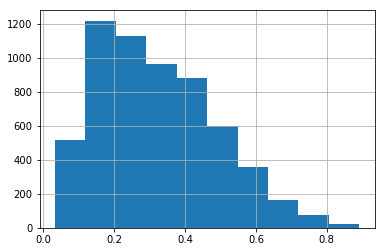

In [44]:
dtrain["predict"] = preds
dtrain.predict[:5]
if verboseout:
    dtrain.predict.hist()

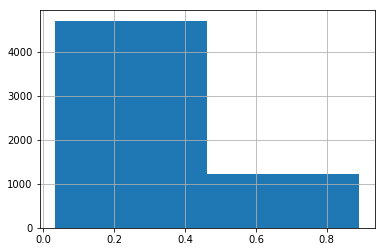

In [45]:
if verboseout:
    dtrain.predict.hist(bins=2)

In [46]:
# print(type(apar_ds['Time_to_relief'].iloc[0]))
print(type(preds))
print(preds.shape)
print(type(dtrain.target))

<class 'numpy.ndarray'>
(5936, 1)
<class 'pandas.core.series.Series'>


In [47]:
# get rounded predictions 
dtrain["predround"] = preds.round().astype(int)
dtrain.predround[:5]

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


2376    0
1386    0
3158    0
5659    0
6361    0
Name: predround, dtype: int64

In [48]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dtrain.target[:100000] - dtrain.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct train")
print((len(deltatr) - deltatr.sum())/len(deltatr))



862.0
percentage correct train
0.854784366577


In [49]:
# predict values for validation X values
# X_valid, dvalid.target
predval = loaded_model.predict(X_valid, batch_size=BATCH_SIZE)
dvalid["predround"] = predval.round().astype(int)
dvalid["predict"] = predval
#print(type(deltaval))
#print(len(deltaval))
dvalid.predict[:5]





/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


1764    0.083393
1567    0.290425
7406    0.444782
2656    0.122015
1903    0.479150
Name: predict, dtype: float32

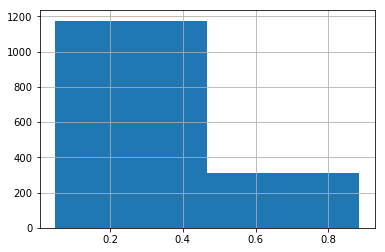

In [50]:
if verboseout:
    dvalid.predict.hist(bins=2)

In [51]:
# hand calculation of proportion correct guesses in validation set

dvalid["deltaval"] = abs(dvalid.target - dvalid.predround)
print(dvalid["deltaval"][:10])
print(dvalid["deltaval"].sum())
# print("percentage correct")
# print((len(deltaval) - deltaval.sum())/len(deltaval))


1764    0.0
1567    0.0
7406    0.0
2656    0.0
1903    0.0
7195    1.0
5732    1.0
6326    0.0
4728    0.0
5966    0.0
Name: deltaval, dtype: float64
238.0


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
# get subset of dataframe with wrong guesses
# k1 = df.loc[(df.Product == p_id)
dvalidwrong = dvalid.loc[(dvalid.deltaval == 1)]
dvalidright = dvalid.loc[(dvalid.deltaval == 0)]
dvalidwrong.head(20)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,OWNERSHIP_CHANGES,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target,predround,predict,deltaval
7195,TS000162016,216,80,0,1,1,1492,1,"[49, 331, 63, 24, 105, 32]",1669,1309,0.0,1,0.526929,1.0
5732,TS000642635,240,88,0,4,1,1641,4,"[52, 271, 163, 325, 36, 253, 894, 38, 358, 441...",418,2570,0.0,1,0.551306,1.0
7139,TS000939651,213,106,0,4,1,1235,0,"[63, 773, 9, 54, 82, 515, 296, 5, 11, 10]",1817,2570,0.0,1,0.536228,1.0
5649,TS000884796,235,43,0,4,0,1054,0,[52],1669,958,0.0,1,0.585885,1.0
153,TS000145418,13,66,0,4,0,1783,0,"[4576, 177, 68, 136, 1, 21, 7]",1343,2570,0.0,1,0.559934,1.0
5668,TS000107955,239,4,0,4,1,1994,1,"[219, 54, 209, 5, 192, 2613, 55, 1192, 2614, 1...",1582,2570,0.0,1,0.593979,1.0
617,TS000892227,217,45,0,4,1,1941,0,"[236, 76, 256, 200, 2345, 130, 2346, 773, 54, ...",481,2570,0.0,1,0.575274,1.0
7448,TS000893664,30,45,0,1,0,1608,0,"[303, 2083, 92, 1643, 697, 355, 70]",78,2570,0.0,1,0.566218,1.0
5988,TS000828846,76,95,0,4,1,1475,1,"[15, 12, 20]",820,2570,0.0,1,0.573079,1.0
7374,TS000169336,30,28,0,4,0,717,1,"[10, 681, 1464, 478, 16, 882, 2, 189, 1998]",1282,2570,0.0,1,0.589914,1.0


In [53]:
dvalidright.head(20)

,CASE_NUMBER,CASE_OWNER_ALIAS,OPENED_DATE,SUPPORT_MISSION,PRODUCT_NAME,SEVERITY_LEVEL_NUMBER_FORMULA,ACCOUNT_NAME,OWNERSHIP_CHANGES,SUBJECT,CREATED_BY,LEGACY_PROBLEM_NUMBER,target,predround,predict,deltaval
1764,TS000879377,117,41,0,4,2,242,1,"[3, 23, 1]",1669,1089,0.0,0,0.083393,0.0
1567,TS000926211,116,104,0,4,2,626,2,"[49, 93, 195, 3, 23, 1, 59, 43, 15, 718, 76, 516]",1669,1162,0.0,0,0.290425,0.0
7406,TS000798340,20,90,0,1,1,2013,0,"[48, 96, 12, 506, 1, 5050, 44, 25, 2604]",1820,2570,0.0,0,0.444782,0.0
2656,TS000175153,142,33,0,4,2,1493,1,"[3, 39, 467, 494, 578, 734, 64, 2, 113, 158, 1...",499,2570,0.0,0,0.122015,0.0
1903,TS000178524,18,35,0,4,1,1471,0,"[104, 5619, 9, 54, 1159, 5620, 1305]",1139,2570,0.0,0,0.479150,0.0
6326,TS000113834,11,48,0,4,2,1270,1,"[388, 501, 43, 5941, 4, 10, 16, 229, 466, 5942...",632,2570,0.0,0,0.199400,0.0
4728,TS000150111,78,71,0,4,3,1130,1,"[1, 38, 5613, 669, 5614]",2,2570,0.0,0,0.093858,0.0
5966,TS000118033,76,54,0,4,1,702,0,"[10, 41, 2, 1708, 26, 571, 293, 185, 1247]",2053,2570,0.0,0,0.429709,0.0
7390,TS000180699,27,83,0,1,3,599,2,"[1, 33, 417, 66, 174, 105]",330,2570,0.0,0,0.290683,0.0
1403,TS000138899,12,20,0,4,2,1879,0,"[397, 15, 127, 1159, 1297, 1216, 1305]",1537,2570,0.0,0,0.293292,0.0


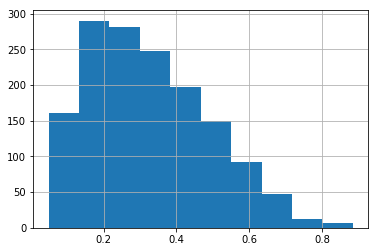

In [54]:
# dvalid.hist(range = (0,5))
# apar_ds.Time_to_relief.hist(range = (0,5))
dvalid.predict.hist()

In [55]:
# ,encoding = "ISO-8859-1"
if dsxmode == False:
    dvalidwrong.to_csv('/home/paperspace/data/dmprediction/dvalidwrongmay20.csv')

In [56]:
dtrain.target[:50]

2376    0.0
1386    0.0
3158    0.0
5659    0.0
6361    0.0
1496    0.0
2011    0.0
5880    0.0
1696    0.0
3397    0.0
2870    0.0
1114    0.0
7018    0.0
5739    0.0
5783    0.0
3805    0.0
4710    0.0
643     0.0
3380    0.0
4704    0.0
2633    0.0
6631    0.0
3875    0.0
4600    0.0
6087    0.0
2118    0.0
6449    0.0
3382    0.0
2296    0.0
125     0.0
4507    0.0
2380    0.0
1381    0.0
5646    0.0
4034    0.0
6810    0.0
5839    0.0
1679    0.0
795     0.0
491     0.0
109     0.0
4751    0.0
7459    0.0
3418    0.0
6146    0.0
6237    0.0
5693    0.0
1966    0.0
2502    0.0
1295    0.0
Name: target, dtype: float64

In [57]:
# get delta between predictions on training set and actual training target values
# hand calculate accuracy on training set as ratio of (total training samples - wrong training predictions)/total training samples

deltatr = abs(dvalid.target[:100000] - dvalid.predround[:100000])
deltatr[:50]
print(deltatr.sum())
print("percentage correct validate")
print((len(deltatr) - deltatr.sum())/len(deltatr))


238.0
percentage correct validate
0.839730639731


In [58]:
# chart accuracy and loss for train and validation sets

print(modelfit.history.keys())
#  acc
plt.plot(modelfit.history['acc'])
plt.plot(modelfit.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# Loss
plt.plot(modelfit.history['loss'])
plt.plot(modelfit.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'modelfit' is not defined

# Confusion matrix <a name='confusionmatrix' />
<a href=#linkanchor>Back to link list</a>

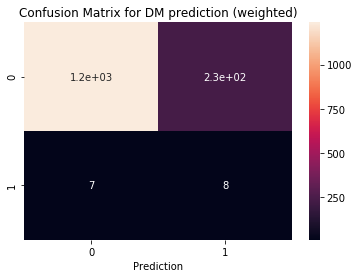

In [59]:
from sklearn import metrics

cfmap=metrics.confusion_matrix(y_true=dvalid['target'],  # True labels
                         y_pred=dvalid["predround"])

label = ["0", "1"]
sns.heatmap(cfmap, annot = True, xticklabels = label, yticklabels = label)
plt.xlabel("Prediction")
plt.title("Confusion Matrix for DM prediction (weighted)")
plt.show()

In [ ]:
model.metrics_names

# Kaggle submission that was used as input for this notebook
https://www.kaggle.com/knowledgegrappler/a-simple-nn-solution-with-keras-0-48611-pl

# Summary
This notebook shows methods for dealing with structured data in the context of a neural network.

# Author

Mark Ryan is a manager at IBM Canada.

Copyright © IBM Corp. 2018. This notebook and its source code are released under the terms of the MIT License.